The goal of this notebook is to check the performance of various formulations

In [3]:
using Pkg; Pkg.activate()
using Serialization
using nGraph, Runner, Zoo
using JuMP, Interact, DataStructures
using PrettyTables

using Plots
gr()

Plots.GRBackend()

In [47]:
function perf_plot(simple, synchronous;
        use_predicted_simple = false, 
        use_predicted_synchronous = false,
        title = "",
        subtract_movetime = false,
        cached_mode = nothing,
        circle = nothing
    )
    io_size = simple.io_sizes[]

    # Sanity check
    @assert io_size == synchronous.io_sizes[]

    # Show the IO size in GB
    #@show io_size / 1E9

    total_dram = simple.default_alloc_size[] + io_size
    @show total_dram
    
    simple_runtimes = use_predicted_simple ? simple.predicted_runtimes ./ 1E6 : simple.actual_runtimes
    synchronous_runtimes = use_predicted_synchronous ? synchronous.predicted_runtimes ./ 1E6 : synchronous.actual_runtimes
    
    dram_performance = min(
        #last(simple_runtimes),
        last(synchronous_runtimes),
    )
    
    plt = plot()
    hline!(plt, [1],
        lab = "",
        linecolor = :black,
        linewidth = 0.1,
        linealpha = 0.5,
    )
    if !isnothing(cached_mode)
        hline!(plt, [last(cached_mode) ./ dram_performance],
            lab = "",
            linecolor = :black,
            linewidth = 0.1,
            linealpha = 0.5,
        )
    end

    static_x = (simple.dram_alloc_size .+ io_size) ./ 1E9
    static_y = (simple_runtimes ./ dram_performance)
    plt = plot!(plt,
        static_x,
        static_y,
        marker = :square,
        label = use_predicted_simple ? "Predicted Static ILP" : "Static ILP",
        minorgrid = true,
        color = :steelblue2,
        fmt = :png,
    )

    synchronous_x = (synchronous.dram_alloc_size .+ io_size) ./ 1E9
    synchronous_y = synchronous_runtimes ./ dram_performance
    plot!(plt,
        synchronous_x,
        synchronous_y,
        marker = :o,
        color = :darkorange1,
        label = use_predicted_synchronous ? "Predicted Synchronous ILP" : "Synchronous ILP",
    )
    
    if subtract_movetime
        plot!(plt,
            (synchronous.dram_alloc_size .+ io_size) ./ 1E9,
            ((synchronous_runtimes .- synchronous.move_time ./ 1E6) ./ dram_performance),
            label = "Subtracting Movetime"
        )
    end
    
    if !isnothing(cached_mode)
        plot!(plt,
            [first(cached_mode)],
            [last(cached_mode)] ./ dram_performance,
            marker = :utriangle,
            markersize = 5,
            label = "2LM Performance (192GB DRAM cache)",
        )
        
        # Plot Annotation for UPI
        y_max = max(maximum(synchronous_y), maximum(static_y))
        vert = 200
        str = """
        DRAM limit for a single socket.
        DRAM pool for Static and Synchronous
        split across sockets.
        """
        annotate!(plt, vert, (y_max+1)/2, text(str, 8, :left, :monospace))
        vline!(plt, [192], lab = "")
    end

    title!(plt, title)
    ylabel!(plt, "Slowdown vs All DRAM")
    xlabel!(plt, "Total DRAM Usage (GB)")
    
    # Draw arrows
    # Find where synchronous is closest to 2LM
    ind = findfirst(y -> y < last(cached_mode) / dram_performance, synchronous_y)
    x = [60, synchronous_x[ind]]
    y = [1.75, synchronous_y[ind]]
    plot!(plt, x, y, arrow = 0.4, lab = "", color = :black)
    annotate!(plt, first(x), first(y), text(" C", 16, :left))
    
    # Annotate last performance equaivlant to All DRAM
    ind = findfirst(y -> y < 1, synchronous_y)
    x = [120, synchronous_x[ind]]
    y = [1.5, synchronous_y[ind]]
    plot!(plt, x, y, arrow = 0.4, lab = "", color = :black)
    annotate!(plt, first(x), first(y), text(" A", 16, :left))
    
    # Plot Circle
    if !isnothing(circle)
        plot!(plt, first(circle), last(circle),
            lab = "",
            color = :black
        )
        annotate!(plt, maximum(first(circle)), maximum(last(circle)),
            text(" B", 16, :left)
        )
    end
    
    # Show the slowdown of the various methods at the 2LM point
    if !isnothing(cached_mode)
        println("Cached Mode Slowdown: ", last(cached_mode) / dram_performance)
        ind = last(findmin(map(x -> abs(first(cached_mode) - x), synchronous_x)))
        println("Synchronous Slowdown: ", synchronous_y[ind])  
        ind = last(findmin(map(x -> abs(first(cached_mode) - x), static_x)))
        println("Static Slowdown: ", static_y[ind])
    end
    
    table = pretty_table(
        hcat(
            synchronous_x ./ (total_dram ./ 1E9),
            synchronous_y,
            static_x ./ (total_dram ./ 1E9),
            static_y,
        ),
        [
            "Synchronous DRAM",
            "Synchronous Overhead",
            "Static DRAM",
            "Static Overhead"
        ],
        formatter = Dict(0 => (v,i) -> round(v, digits = 3))
    )

    display(table)

    return plt
end

perf_plot (generic function with 1 method)

total_dram = 336817867588
Cached Mode Slowdown: 1.1006854359965035
Synchronous Slowdown: 0.9876993403301783
Static Slowdown: 1.0964577626628993
┌──────────────────┬──────────────────────┬─────────────┬─────────────────┐
│ Synchronous DRAM │ Synchronous Overhead │ Static DRAM │ Static Overhead │
├──────────────────┼──────────────────────┼─────────────┼─────────────────┤
│            0.014 │                3.146 │       0.014 │           3.171 │
│            0.035 │                1.031 │       0.037 │           1.393 │
│            0.049 │                1.013 │       0.051 │           1.383 │
│            0.069 │                1.008 │       0.069 │           1.362 │
│            0.089 │                1.007 │       0.092 │           1.354 │
│             0.11 │                1.004 │       0.112 │            1.34 │
│            0.136 │                1.001 │       0.141 │           1.318 │
│            0.167 │                  1.0 │       0.169 │           1.311 │
│            0.201 │

nothing

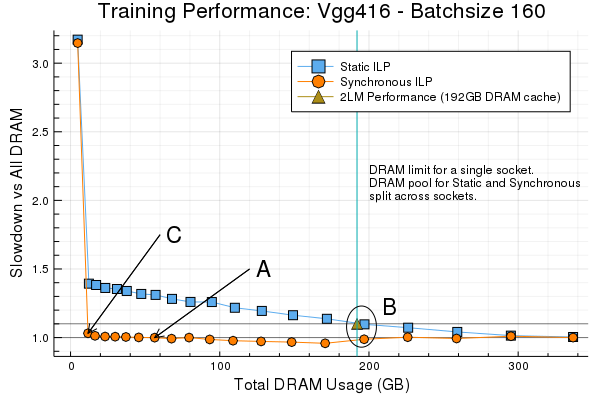

In [48]:
simple_data = deserialize("serials/static_vgg416_160.jls")
synchronous_data = deserialize("serials/synchronous_vgg416_160.jls")
title = "Training Performance: Vgg416 - Batchsize 160"

cached_mode = (192, 341.6)

circle(a, b, x, y) = (
    [x + a*cos(t) for t in range(0, 2*pi; length = 1000)],
    [y + b*sin(t) for t in range(0, 2*pi; length = 1000)]
)
# Circle for labeling

perf_plot(
    simple_data,
    synchronous_data;
    use_predicted_simple = false,
    use_predicted_synchronous = false,
    title = title,
    subtract_movetime = false,
    cached_mode = cached_mode,
    circle = circle(10, 0.15, 195, 1.08)
)

nothing

total_dram = 329390843204
Cached Mode Slowdown: 1.3507278908910618
Synchronous Slowdown: 0.964596691859158
Static Slowdown: 1.097327756131658
┌──────────────────┬──────────────────────┬─────────────┬─────────────────┐
│ Synchronous DRAM │ Synchronous Overhead │ Static DRAM │ Static Overhead │
├──────────────────┼──────────────────────┼─────────────┼─────────────────┤
│            0.011 │                3.883 │       0.011 │           3.858 │
│            0.034 │                2.562 │       0.029 │           2.969 │
│            0.061 │                1.789 │       0.045 │           2.414 │
│            0.072 │                1.499 │       0.074 │           2.096 │
│            0.117 │                1.198 │       0.095 │           1.851 │
│            0.121 │                1.121 │       0.122 │           1.683 │
│            0.165 │                1.083 │       0.165 │           1.594 │
│            0.165 │                1.068 │       0.182 │           1.517 │
│             0.23 │  

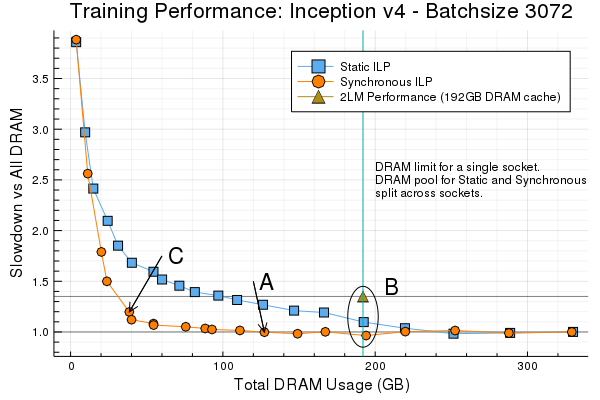

In [50]:
simple_data = deserialize("serials/static_inception_v4_3072.jls")
synchronous_data = deserialize("serials/synchronous_inception_v4_3072.jls")
title = "Training Performance: Inception v4 - Batchsize 3072"

cached_mode = (192, 196.8)

perf_plot(
    simple_data,
    synchronous_data;
    use_predicted_simple = false,
    use_predicted_synchronous = false,
    title = title,
    subtract_movetime = false,
    cached_mode = cached_mode,
    circle = circle(10, 0.3, 192, 1.15)
)

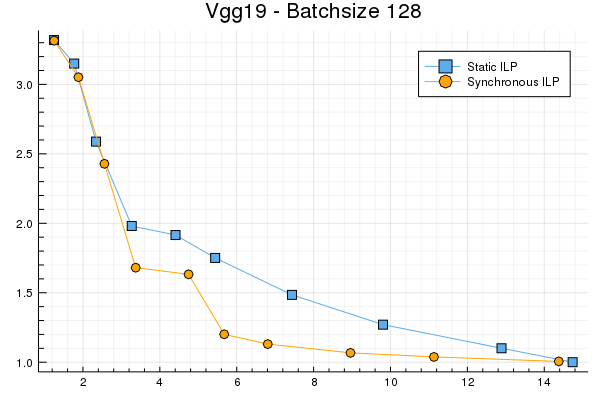

In [26]:
static = deserialize("serials/vgg19_batchsize_128_static.jls")
synchronous = deserialize("serials/vgg19_batchsize_128_synchronous.jls")
title = "Vgg19 - Batchsize 128"

#####
##### Plot Static
#####
io_size = static.io_sizes[]
total_dram = static.default_alloc_size[] + io_size

static_runtimes = static.actual_runtimes

dram_performance = min(
    minimum(static_runtimes),
    minimum(synchronous_runtimes),
)

static_x = (static.dram_alloc_size .+ io_size) ./ 1E9
static_y = (static_runtimes ./ dram_performance)
plt = plot(
    static_x,
    static_y,
    marker = :square,
    label = "Static ILP",
    minorgrid = true,
    color = :steelblue2,
    fmt = :png,
)

#####
##### Plot Synchronous
#####
io_size = synchronous.io_sizes[]
total_dram = synchronous.default_alloc_size[] + io_size

synchronous_runtimes = synchronous.actual_runtimes

synchronous_x = (synchronous.dram_alloc_size .+ io_size) ./ 1E9
synchronous_y = (synchronous_runtimes ./ dram_performance)
plot!(plt,
    synchronous_x,
    synchronous_y,
    marker = :o,
    label = "Synchronous ILP",
    minorgrid = true,
    color = :orange,
    fmt = :png,
)

title!(plt, title)
# Dump the plot
plt